## Model K-Means

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Clustering e métricas de distância
from sklearn.cluster import KMeans
from scipy.spatial import distance

# Pré-processamento
from sklearn.preprocessing import OneHotEncoder

# Avaliação do modelo
from sklearn.metrics import silhouette_score

# Pipeline e redução dimensional
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Método do cotovelo para KMeans
from yellowbrick.cluster import KElbowVisualizer

# Configuração para exibir todas as colunas
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
df = pd.read_csv('../data/marketing_campaign_clean.csv').dropna()
df.drop(['Dt_Customer', 'Year', 'Month', 'Day', 'SeniorityDays', 'Date'], axis=1, inplace=True)

print(df.shape)
print(df.info())
df.head()

(2206, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2206 non-null   int64 
 1   Year_Birth           2206 non-null   int64 
 2   Education            2206 non-null   object
 3   Marital_Status       2206 non-null   object
 4   Income               2206 non-null   int64 
 5   Kidhome              2206 non-null   int64 
 6   Teenhome             2206 non-null   int64 
 7   Age                  2206 non-null   int64 
 8   Recency              2206 non-null   int64 
 9   Complain             2206 non-null   int64 
 10  Children             2206 non-null   int64 
 11  FamilySize           2206 non-null   int64 
 12  IsMarried            2206 non-null   int64 
 13  MntWines             2206 non-null   int64 
 14  MntFruits            2206 non-null   int64 
 15  MntMeatProducts      2206 non-null   int64 


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Age,Recency,Complain,Children,FamilySize,IsMarried,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalMntSpent,TotalPurchases,AvgPurchaseValue,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedAnyCampaign,Response,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,WebVsStorePurchases
0,5524,1957,Graduation,Single,58138,0,0,57,58,0,0,0,0,635,88,546,172,88,88,1617,25,64,3,0,0,0,0,0,0,1,8,10,4,7,2
1,2174,1954,Graduation,Single,46344,1,1,60,38,0,2,2,0,11,1,6,2,1,6,27,6,4,2,0,0,0,0,0,0,0,1,1,2,5,0
2,4141,1965,Graduation,Together,71613,0,0,49,26,0,0,1,1,426,49,127,111,21,42,776,21,36,1,0,0,0,0,0,0,0,8,2,10,4,0
3,6182,1984,Graduation,Together,26646,1,0,30,26,0,1,2,1,11,4,20,10,3,5,53,8,6,2,0,0,0,0,0,0,0,2,0,4,6,0
4,5324,1981,PhD,Married,58293,1,0,33,94,0,1,2,1,173,43,118,46,27,15,422,19,22,5,0,0,0,0,0,0,0,5,3,6,5,0


In [3]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
features = numerical_cols.drop("ID")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

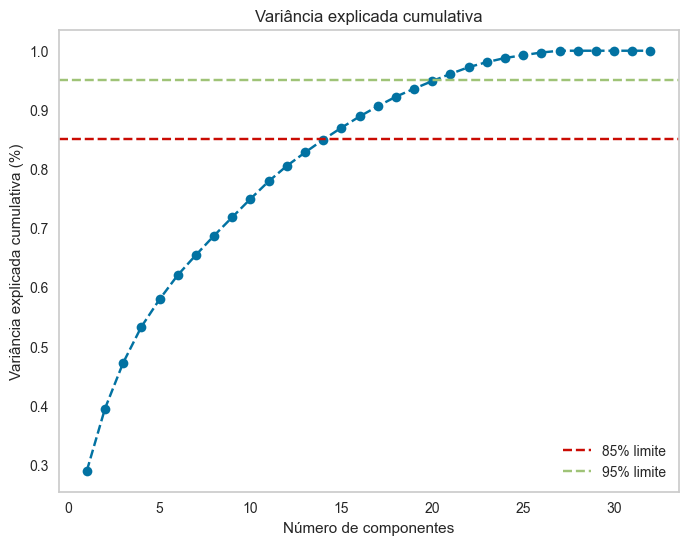

Número de componentes que explicam pelo menos 85% da variância: 15


In [4]:
pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Variância explicada cumulativa')
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada cumulativa (%)')
plt.axhline(y=0.85, color='r', linestyle='--', label='85% limite')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% limite')
plt.legend()
plt.grid()
plt.show()

threshold = 0.85
optimal_components = np.argmax(np.cumsum(explained_variance) >= threshold) + 1
print(f"Número de componentes que explicam pelo menos 85% da variância: {optimal_components}")

In [5]:
# PCA
pca = PCA(random_state=42, n_components=15)
principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 
                                                          'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15'])
pca_df['ID'] = df['ID']

In [6]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,ID
0,4.840995,0.103643,-0.145926,2.091788,4.214282,0.428195,-0.038317,0.096654,1.062277,-0.034825,-2.595879,1.415920,-0.252255,-0.386527,-1.217797,5524
1,-3.031801,0.470791,-0.605196,-1.843653,0.559017,0.139889,-1.708640,1.114804,-0.077675,-0.844983,-1.142491,0.209771,-0.614120,0.238236,-0.036314,2174
2,2.095488,-0.386209,-1.627539,-0.013175,0.557218,-0.482862,-0.013240,-1.182834,-0.160004,0.418484,0.927829,-0.306847,0.395903,0.165867,-0.084188,4141
3,-2.971885,-1.803144,0.091349,0.654174,-0.986096,-0.076721,-0.155867,-0.988566,0.011724,0.228455,0.375684,-0.214119,0.359362,-0.014240,0.009748,6182
4,-0.524957,-0.241898,-0.579134,1.662048,-1.521707,-0.419675,0.919647,0.615902,0.030521,0.010605,-0.325570,0.188707,1.145782,-0.584771,-0.324462,5324


In [7]:
pca_df.shape

(2206, 16)

In [8]:
df_model = pca_df.drop('ID', axis=1)
padronizador = StandardScaler()
df_padronizado = padronizador.fit_transform(df_model)

In [9]:
padronizador

StandardScaler()

In [10]:
df_padronizado

array([[ 1.59029093,  0.05648283, -0.09268301, ..., -0.29620925,
        -0.46425414, -1.5169311 ],
       [-0.99596167,  0.25656916, -0.38438345, ..., -0.72112584,
         0.28614313, -0.04523432],
       [ 0.6883783 , -0.21047405, -1.03371335, ...,  0.46488637,
         0.19922174, -0.1048679 ],
       ...,
       [ 0.80297833, -0.65929864,  0.83747568, ...,  1.32290651,
         1.02035177, -2.25363157],
       [ 0.60914365,  0.97919234, -1.12003179, ..., -0.31020529,
         0.06005204,  0.29189069],
       [-0.78076435,  1.04996768,  0.2988651 , ...,  0.78623659,
        -1.34477904, -0.19990668]])

In [11]:
num_features = list(df_model.select_dtypes('number').columns)
cat_features = list(df_model.select_dtypes('object').columns)

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)  # Drop='first' para evitar multicolinearidade
    ])

In [13]:
X_preprocessed = preprocessor.fit_transform(df_model)

In [14]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
                                  'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12',
                                  'PC13', 'PC14', 'PC15']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 [])])

In [15]:
X_preprocessed

array([[ 1.59029093,  0.05648283, -0.09268301, ..., -0.29620925,
        -0.46425414, -1.5169311 ],
       [-0.99596167,  0.25656916, -0.38438345, ..., -0.72112584,
         0.28614313, -0.04523432],
       [ 0.6883783 , -0.21047405, -1.03371335, ...,  0.46488637,
         0.19922174, -0.1048679 ],
       ...,
       [ 0.80297833, -0.65929864,  0.83747568, ...,  1.32290651,
         1.02035177, -2.25363157],
       [ 0.60914365,  0.97919234, -1.12003179, ..., -0.31020529,
         0.06005204,  0.29189069],
       [-0.78076435,  1.04996768,  0.2988651 , ...,  0.78623659,
        -1.34477904, -0.19990668]])

In [16]:
kmeans = KMeans(random_state=42)

param_grid = {
    'init': ['k-means++', 'random'],
    'max_iter': [100, 300, 500, 1000, 1100, 2000],
    'tol': [1e-4, 1e-3],
    'algorithm': ['auto', 'full', 'elkan']
}

grid_search = GridSearchCV(kmeans, param_grid, cv=3)

grid_search.fit(X_preprocessed)

print("Best parameters found: ", grid_search.best_params_, "\n")

c:\Users\schit\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\schit\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Best parameters found:  {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 100, 'tol': 0.0001} 



c:\Users\schit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
144 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\schit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "c:\Users\schit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\schit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line

c:\Users\schit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1400: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


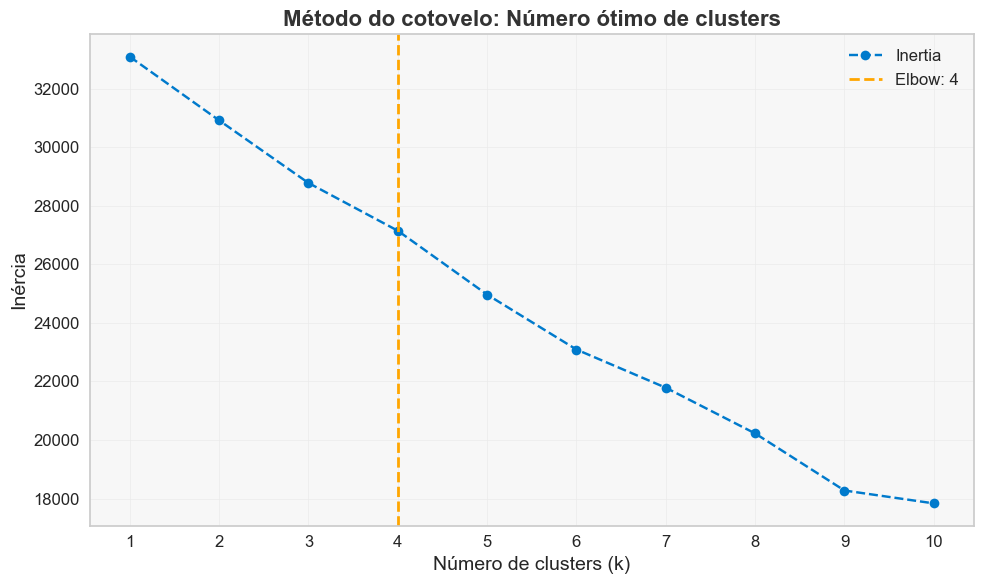

In [17]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=1000, algorithm='elkan', init='k-means++', tol=0.0001)
    kmeans.fit(X_preprocessed)
    inertia.append(kmeans.inertia_)

differences = np.diff(inertia)
elbow_point = np.argmin(differences) + 1

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--', color='#007acc', label='Inertia')
plt.axvline(x=elbow_point, color='#ffa600', linestyle='--', linewidth=2, label=f'Elbow: {elbow_point}')

plt.title('Método do cotovelo: Número ótimo de clusters', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Número de clusters (k)', fontsize=14)
plt.ylabel('Inércia', fontsize=14)
plt.xticks(k_values, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(color='#eaeaea', linestyle='-', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12, loc='best')
plt.gca().set_facecolor('#f7f7f7')

plt.tight_layout()
plt.show()

In [18]:
kmeans = KMeans(n_clusters=3, max_iter=1000, algorithm='elkan', init='k-means++', random_state=42, tol=0.0001)
kmeans.fit(X_preprocessed)
df['grupo'] = kmeans.labels_
df_model['grupo'] = kmeans.labels_

In [19]:
kmeans

KMeans(algorithm='elkan', max_iter=1000, n_clusters=3, random_state=42)

In [20]:
kmeans.labels_

array([2, 1, 2, ..., 2, 1, 1])

In [21]:
pd.DataFrame(df.grupo.value_counts())

,count
grupo,
2,1120
1,1056
0,30


In [22]:
df_model

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,grupo
0,4.840995,0.103643,-0.145926,2.091788,4.214282,0.428195,-0.038317,0.096654,1.062277,-0.034825,-2.595879,1.415920,-0.252255,-0.386527,-1.217797,2
1,-3.031801,0.470791,-0.605196,-1.843653,0.559017,0.139889,-1.708640,1.114804,-0.077675,-0.844983,-1.142491,0.209771,-0.614120,0.238236,-0.036314,1
2,2.095488,-0.386209,-1.627539,-0.013175,0.557218,-0.482862,-0.013240,-1.182834,-0.160004,0.418484,0.927829,-0.306847,0.395903,0.165867,-0.084188,2
3,-2.971885,-1.803144,0.091349,0.654174,-0.986096,-0.076721,-0.155867,-0.988566,0.011724,0.228455,0.375684,-0.214119,0.359362,-0.014240,0.009748,2
4,-0.524957,-0.241898,-0.579134,1.662048,-1.521707,-0.419675,0.919647,0.615902,0.030521,0.010605,-0.325570,0.188707,1.145782,-0.584771,-0.324462,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,2.419116,2.112101,-0.435753,2.238660,1.590954,0.890702,1.788738,-0.767017,0.304511,0.436380,-0.461868,0.868956,-2.285645,1.028564,0.916143,1
2202,-1.284891,5.267837,2.579773,-0.456987,-0.905117,1.392793,0.058212,0.503216,0.968696,-0.483687,-2.541039,-0.537811,1.384189,0.894555,1.829893,1
2203,2.444341,-1.209779,1.318571,-0.552093,-1.496285,-2.869135,1.421475,0.523562,-0.697564,0.595065,1.075072,-1.449650,1.126603,0.849520,-1.809223,2
2204,1.854291,1.796768,-1.763444,-0.766346,-0.010661,0.226777,-1.025109,-0.959950,-0.255028,-0.114484,0.931933,-0.236357,-0.264175,0.049998,0.234331,1


In [23]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Age,Recency,Complain,Children,FamilySize,IsMarried,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalMntSpent,TotalPurchases,AvgPurchaseValue,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedAnyCampaign,Response,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,WebVsStorePurchases,grupo
0,5524,1957,Graduation,Single,58138,0,0,57,58,0,0,0,0,635,88,546,172,88,88,1617,25,64,3,0,0,0,0,0,0,1,8,10,4,7,2,2
1,2174,1954,Graduation,Single,46344,1,1,60,38,0,2,2,0,11,1,6,2,1,6,27,6,4,2,0,0,0,0,0,0,0,1,1,2,5,0,1
2,4141,1965,Graduation,Together,71613,0,0,49,26,0,0,1,1,426,49,127,111,21,42,776,21,36,1,0,0,0,0,0,0,0,8,2,10,4,0,2
3,6182,1984,Graduation,Together,26646,1,0,30,26,0,1,2,1,11,4,20,10,3,5,53,8,6,2,0,0,0,0,0,0,0,2,0,4,6,0,2
4,5324,1981,PhD,Married,58293,1,0,33,94,0,1,2,1,173,43,118,46,27,15,422,19,22,5,0,0,0,0,0,0,0,5,3,6,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,10870,1967,Graduation,Married,61223,0,1,47,46,0,1,2,1,709,43,182,42,118,247,1341,18,74,2,0,0,0,0,0,0,0,9,3,4,5,2,1
2202,4001,1946,PhD,Together,64014,2,1,68,56,0,3,4,1,406,0,30,0,0,8,444,22,20,7,1,0,0,0,0,1,0,8,2,5,7,1,1
2203,7270,1981,Graduation,Divorced,56981,0,0,33,91,0,0,1,1,908,48,217,32,12,24,1241,19,65,1,0,0,0,1,0,1,0,2,3,13,6,0,2
2204,8235,1956,Master,Together,69245,0,1,58,8,0,1,2,1,428,30,214,80,30,61,843,23,36,2,0,0,0,0,0,0,0,6,5,10,3,0,1


In [24]:
#sns.pairplot(df_model, hue='grupo')

In [25]:
#sns.pairplot(df[['Income', 'Age', 'FamilySize', 'IsMarried', 'Recency', 'grupo']], hue='grupo')

In [26]:
#df.to_csv('ClusteredData.csv', index=False)

	ID	Year_Birth	Education	Marital_Status	Income	Kidhome	Teenhome	Age	Recency	Complain	Children	FamilySize	IsMarried	MntWines	MntFruits	MntMeatProducts	MntFishProducts	MntSweetProducts	MntGoldProds	TotalMntSpent	TotalPurchases	AvgPurchaseValue	NumDealsPurchases	AcceptedCmp1	AcceptedCmp2	AcceptedCmp3	AcceptedCmp4	AcceptedCmp5	AcceptedAnyCampaign	Response	NumWebPurchases	NumCatalogPurchases	NumStorePurchases	NumWebVisitsMonth	WebVsStorePurchases	grupo
0	5524	1957	Graduation	Single	58138	0	0	57	58	0	0	0	0	635	88	546	172	88	88	1617	25	64	3	0	0	0	0	0	0	1	8	10	4	7	2	1
1	2174	1954	Graduation	Single	46344	1	1	60	38	0	2	2	0	11	1	6	2	1	6	27	6	4	2	0	0	0	0	0	0	0	1	1	2	5	0	3
2	4141	1965	Graduation	Together	71613	0	0	49	26	0	0	1	1	426	49	127	111	21	42	776	21	36	1	0	0	0	0	0	0	0	8	2	10	4	0	3
3	6182	1984	Graduation	Together	26646	1	0	30	26	0	1	2	1	11	4	20	10	3	5	53	8	6	2	0	0	0	0	0	0	0	2	0	4	6	0	2
4	5324	1981	PhD	Married	58293	1	0	33	94	0	1	2	1	173	43	118	46	27	15	422	19	22	5	0	0	0	0	0	0	0	5	3	6	5	0	2
5	7446	1967	Master	Together	62513	0	1	47	16	0	1	2	1	520	42	98	0	42	14	716	22	32	2	0	0	0	0	0	0	0	6	4	10	6	0	3


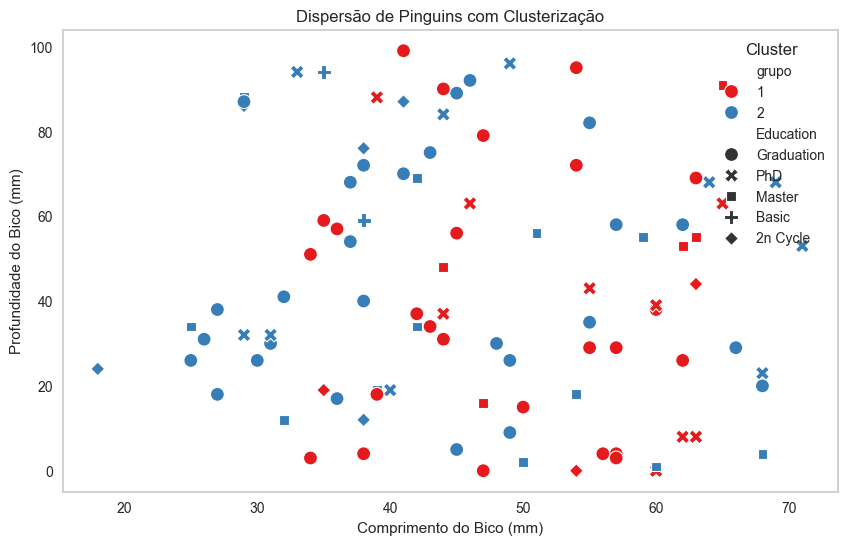

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.head(100), x='Age', y='Recency', hue='grupo', palette='Set1', style='Education', s=100)
plt.title('Dispersão de Pinguins com Clusterização')
plt.xlabel('Comprimento do Bico (mm)')
plt.ylabel('Profundidade do Bico (mm)')
plt.legend(title='Cluster', loc='upper right')
plt.grid()
plt.show()

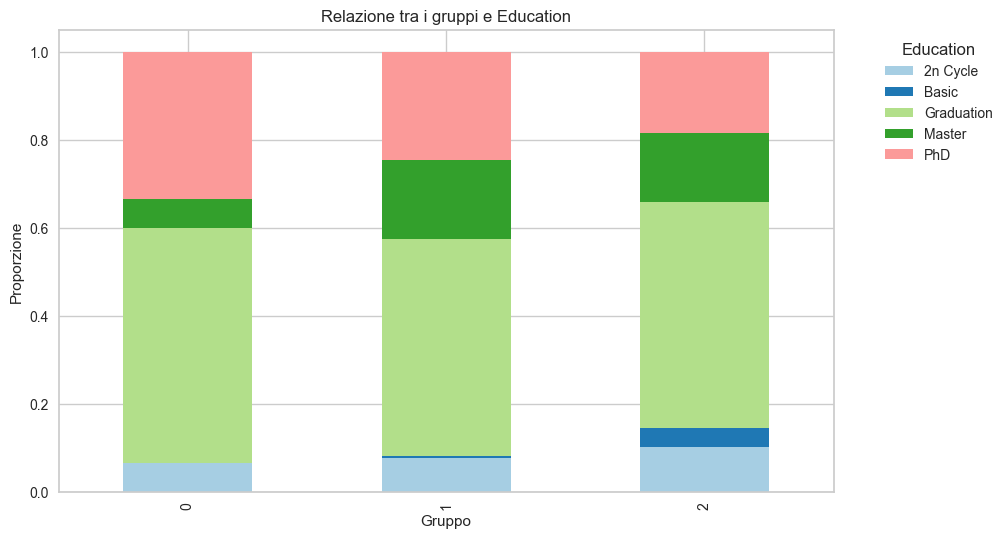

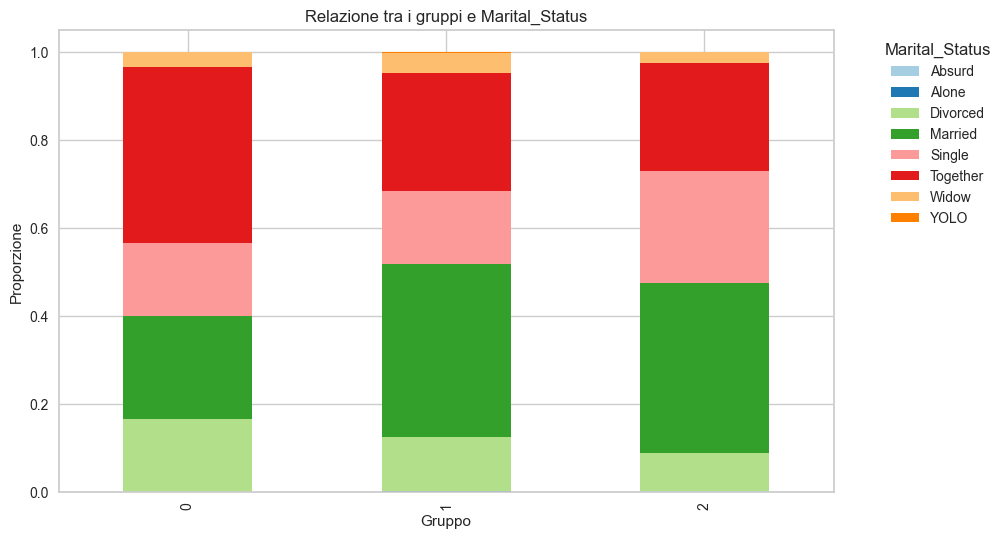

In [28]:
# Identificare le colonne categoriche
categorical_columns = df.select_dtypes(include=['object']).columns

# Creare un grafico per ciascuna colonna categorica
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    crosstab = pd.crosstab(df['grupo'], df[column], normalize='index')
    crosstab.plot(kind='bar', stacked=True, color=plt.cm.Paired.colors, ax=plt.gca())
    plt.title(f'Relazione tra i gruppi e {column}')
    plt.xlabel('Gruppo')
    plt.ylabel('Proporzione')
    plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

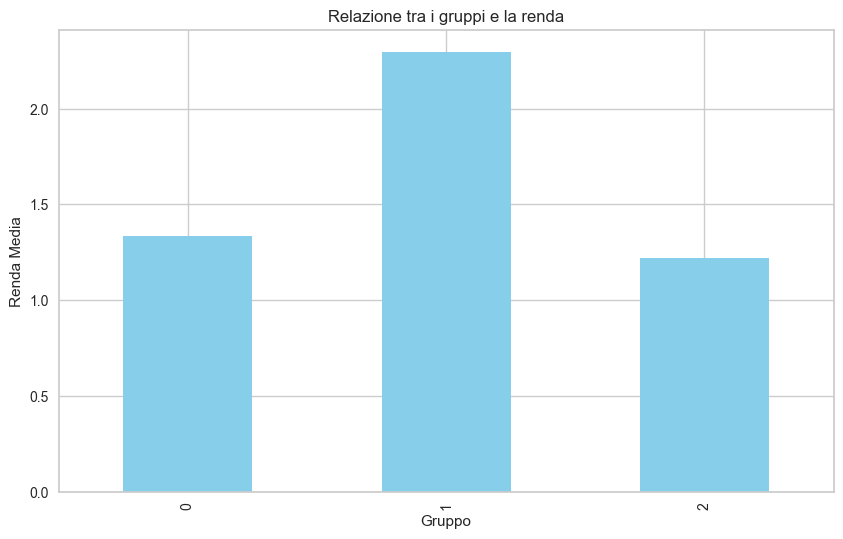

In [29]:
# Creare il grafico
plt.figure(figsize=(10, 6))

# Creare un grafico a barre per mostrare la relazione tra i gruppi e la renda
df.groupby('grupo')['FamilySize'].mean().plot(kind='bar', color='skyblue')

# Aggiungere titolo e etichette agli assi
plt.title('Relazione tra i gruppi e la renda')
plt.xlabel('Gruppo')
plt.ylabel('Renda Media')

# Mostrare il grafico
plt.show()

In [30]:
"""# Identificare le colonne numeriche
numeric_columns = df.select_dtypes(include=['number']).columns

# Creare un grafico per ciascuna colonna numerica
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    df.groupby('grupo')[column].mean().plot(kind='bar', color='skyblue')
    plt.title(f'Relazione tra i gruppi e {column}')
    plt.xlabel('Gruppo')
    plt.ylabel(f'{column} Medio')
    plt.show()"""

"# Identificare le colonne numeriche\nnumeric_columns = df.select_dtypes(include=['number']).columns\n\n# Creare un grafico per ciascuna colonna numerica\nfor column in numeric_columns:\n    plt.figure(figsize=(10, 6))\n    df.groupby('grupo')[column].mean().plot(kind='bar', color='skyblue')\n    plt.title(f'Relazione tra i gruppi e {column}')\n    plt.xlabel('Gruppo')\n    plt.ylabel(f'{column} Medio')\n    plt.show()"